# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu

In [4]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [5]:
from scipy.stats import linregress

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [8]:
FONTSIZE = 20

In [9]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [10]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [11]:
CHANNEL_MAP_AND_ALL_TRIALS_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")
MERGED_TRIALS_AND_VIDEO = pd.read_pickle("./proc/trial_SLEAP_and_metadata.pkl")

In [12]:
OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3"}

In [13]:
OUTCOME_COMPARISONS = {"win_lose": ("win", "lose"), "lose_omission": ("lose", "omission"), "win_rewarded": ("win", "rewarded")}

In [14]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [15]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [16]:
BIN_TO_DISTANCE = {0: "0 to 5cm", 1: "5cm+"}

In [17]:
MIN_DISTANCE = 0
MAX_DISTANCE = 5

In [18]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 6, "high_freq": 11}, "beta": {"low_freq": 20, "high_freq": 31}, "gamma": {"low_freq": 30, "high_freq": 51}}
BAND_TO_FREQ = {"theta": (6,11), "beta": (20,31), "gamma": (30,51)}

In [19]:
GROUPINGS = "trial_outcome"

In [20]:
FONTSIZE=20

In [21]:
MERGED_TRIALS_AND_VIDEO.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,baseline-trial_subject_thorax-to-agent_distance_chunked,baseline_subject_thorax-to-agent_distance_binned,trial_subject_thorax-to-agent_distance_binned,baseline-trial_subject_thorax-to-agent_distance_binned,baseline_subject-agent_to-reward-port-distance-ratio_chunked,trial_subject-agent_to-reward-port-distance-ratio_chunked,baseline-trial_subject-agent_to-reward-port-distance-ratio_chunked,baseline_subject-agent_to-reward-port-distance-ratio_binned,trial_subject-agent_to-reward-port-distance-ratio_binned,baseline-trial_subject-agent_to-reward-port-distance-ratio_binned
0,4509412,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,1030879,20230617_115521_standard_comp_to_omission_D1_s...,1029,1.0,1-1_t1b3L_box1,lose_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,"[12.65717198847138, 12.683871307928696, 14.880...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0759253122165384, 1.0769129973530136, 1.076...","[8.855775558856838, 8.071331610027782, 6.34917...","[1.0759253122165384, 1.0769129973530136, 1.076...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
1,6909411,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,3430878,20230617_115521_standard_comp_to_omission_D1_s...,3425,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,"[25.320573976061063, 25.371420577329687, 25.41...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12.812376711482205, 12.737960036445987, 12.61...","[5.900235036905437, 5.7618199879648, 5.5222346...","[12.812376711482205, 12.737960036445987, 12.61...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,9209413,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,5730880,20230617_115521_standard_comp_to_omission_D1_s...,5720,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,"[10.449518193779662, 10.328848927104168, 9.348...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.3140549404066315, 2.083627429990607, 1.9285...","[0.14051079708270506, 0.2589369756582887, 0.40...","[1.3140549404066315, 2.083627429990607, 1.9285...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,13109412,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,9630879,20230617_115521_standard_comp_to_omission_D1_s...,9612,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,"[22.46126034089424, 15.271962513097026, 9.7552...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...","[10.605771942059523, 7.690197343693041, 5.6453...","[0.33382427611833676, 0.36024075728364263, 0.2...","[10.605771942059523, 7.690197343693041, 5.6453...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,16509409,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,13030876,20230617_115521_standard_comp_to_omission_D1_s...,13006,1.0,1-1_t

In [22]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,vHPC_baseline-trial_lfp_trace,BLA_baseline_lfp_trace,BLA_trial_lfp_trace,BLA_baseline-trial_lfp_trace,LH_baseline_lfp_trace,LH_trial_lfp_trace,LH_baseline-trial_lfp_trace,MD_baseline_lfp_trace,MD_trial_lfp_trace,MD_baseline-trial_lfp_trace
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.07045184, -0.0958607, -0.054282565, 0.1512...","[2.0367692, 2.1165679, 2.162167, 2.2685654, 2....","[0.31159526, 0.35909453, 0.18239723, -0.509192...","[2.0367692, 2.1165679, 2.162167, 2.2685654, 2....","[3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...","[0.78082824, 1.1788379, 0.8415931, -0.40104795...","[3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...","[1.3860394, 1.4873364, 1.7566382, 1.8208753, 1...","[-0.9857927, -0.8746131, -0.7362562, -1.413216...","[1.3860394, 1.4873364, 1.7566382, 1.8208753, 1..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.30606127, 0.22405995, 0.28873706, 0.4100066...","[0.30589536, 0.13679792, -0.064599015, -0.3381...","[0.020899683, -0.05129922, 0.113998264, -0.416...","[0.30589536, 0.13679792, -0.064599015, -0.3381...","[-1.1575702, -1.2699852, -1.3489795, -1.427973...","[0.91754913, 0.4466216, 0.64410734, 0.03342066...","[-1.1575702, -1.2699852, -1.3489795, -1.427973...","[-0.15318082, -0.16800477, 0.019765267, 0.1605...","[1.620752, 1.3415675, 1.4601592, 0.94132084, -...","[-0.15318082, -0.16800477, 0.019765267, 0.1605..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-1.2300198, -1.2323297, -1.3039365, -1.096045...","[-2.0025697, -1.9151709, -1.9436705, -1.552276...","[0.6896895, 1.3983787, 1.7574733, 1.4287783, 1...","[-2.0025697, -1.9151709, -1.9436705, -1.552276...","[-0.20356221, -0.08203254, -0.18837102, -0.142...","[-0.58941895, 0.25521234, 0.66233677, 0.416239...","[-0.20356221, -0.08203254, -0.18837102, -0.142...","[-0.32859758, -0.5361329, -0.97591007, -0.7609...","[0.088943705, 0.8770837, 1.2056813, 0.88696635...","[-0.32859758, -0.5361329, -0.97591007, -0.7609..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[0.1605378, 0.4169363, 0.64561605, 0.6756447, ...","[-1.2729807, -1.0468841, -0.8378873, -0.754288...","[2.6789594, 2.3939636, 2.2096665, 1.97597, 1.8...","[-1.2729807, -1.0468841, -0.8378873, -0.754288...","[-2.4792056, -2.1480372, -1.8259835, -1.677109...","[2.7587237, 2.233108, 1.4796239, 0.93274033, 1...","[-2.4792056, -2.1480372, -1.8259835, -1.677109...","[-2.7720788, -2.5620728, -2.3125362, -2.062999...","[2.0802944, 1.7344022, 1.1192082, 0.4521305, 0...","[-2.7720788, -2.5620728, -2.3125362, -2.062999..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.30952612, 0.19056645, 0.4331056, 0.3638087...","[-2.1469674, -2.0690687, -2.0937681, -2.152667...","[-0.18809713, 0.108298354, -0.66878986, -0.944...","[-2.1469674, -2.0690687, -2.0937681, -2.152667...","[-2.1176548, -1.4522797, -1.0360405, -1.108958

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [23]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [24]:
def nested_dict():
    return defaultdict(dict)

In [25]:
def mean_of_counter(counter):
    # Extract values from the Counter and calculate the mean
    values = list(counter.values())
    return sum(values) / len(values) if values else 0  # Prevent division by zero

In [26]:
def adjust_lightness(color, amount=0.5):
    """
    Adjusts the lightness of the given color by the provided amount.
    :param color: Input color in some format that matplotlib's `to_rgb` can handle.
    :param amount: Amount to adjust. > 1 for lighter, < 1 for darker.
    :return: Adjusted color.
    """
    import colorsys
    c = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(h, max(0, min(1, amount * l)), s)

In [27]:
def generate_gradient_colors(base_color, num_colors=10):
    """
    Generate gradient colors based on a base color.
    
    :param base_color: The base color to create a gradient from.
    :param num_colors: The number of gradient colors to generate.
    :return: List of colors.
    """
    # Convert base color to HLS (Hue, Lightness, Saturation)
    h, l, s = colorsys.rgb_to_hls(*mcolors.to_rgb(base_color))

    # Determine the step size for lightness
    middle_index = num_colors // 2
    lightness_step = l / (middle_index if middle_index > 0 else 1)

    colors = []
    for i in range(num_colors):
        if i < middle_index:
            # For the lighter colors (before the middle)
            new_lightness = l + (middle_index - i) * lightness_step
        elif i == middle_index:
            # The middle color remains the base color
            new_lightness = l
        else:
            # For the darker colors (after the middle)
            new_lightness = l - (i - middle_index) * lightness_step

        # Ensure new lightness is within the valid range [0, 1]
        new_lightness = max(0, min(new_lightness, 1))

        new_color = colorsys.hls_to_rgb(h, new_lightness, s)
        colors.append(new_color)

    return colors

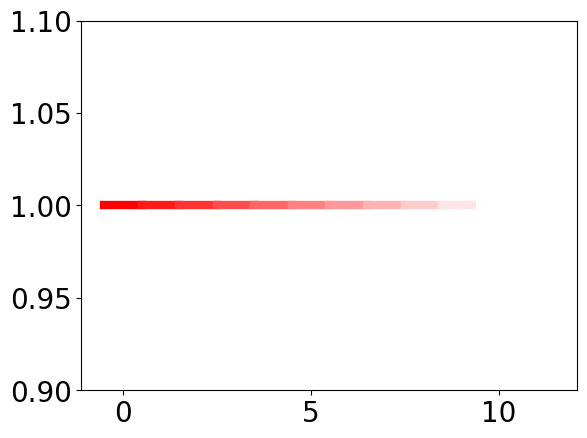

In [28]:
# Original color
original_color = 'red'  # Can be any color matplotlib understands

# Generate lighter versions
lighter_colors = [adjust_lightness(original_color, amount=1+(0.1*i)) for i in range(12)]

# Plotting to demonstrate the colors
for i, color in enumerate(lighter_colors):
    plt.plot([i-0.5, i+0.5], [1, 1], color=color, linewidth=6)  

plt.ylim(0.9, 1.1)
plt.show()

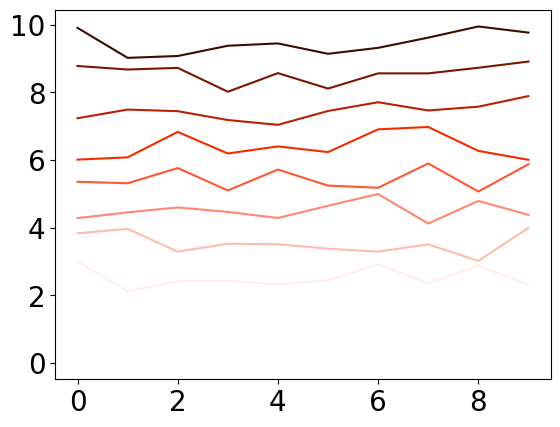

In [29]:
# Base color
base_color = '#ff5733'  # Reddish color

# Number of colors you want in the gradient
num_colors = 10

# Generate gradient colors
gradient_colors = generate_gradient_colors(base_color, num_colors)

# Set the color cycle to use the gradient colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=gradient_colors)

# Test by plotting some data
for i in range(num_colors):
    plt.plot(np.arange(10), np.random.rand(10) + i)

plt.show()

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [30]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [31]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baseline-trial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baseline-trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'BLA_baseline-trial_lfp_trace', 'LH_baseline_lfp_trace',
       'LH_trial_lfp_trace', 'LH_baseline-trial_lfp_trace',
       'MD_baseline_lfp_trace', 'MD_trial_lfp_trace',
       'MD_baseline-trial_lfp_trace'],
      dtype='object')

In [32]:
MERGED_TRIALS_AND_VIDEO.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'track_names', 'subject_and_tracks_list',
       'subject_id', 'agent_id', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'box_bottom_left',
       'reward_po

### Merging LFP Trace dataframe and SLEAP pose tracking

In [33]:
merge_columns = ["time", "recording_file", "current_subject", "video_number"]
# Find columns in df2 that are not in merge_columns and also exist in df1, then drop them from df2
cols_to_drop = [col for col in CHANNEL_MAP_AND_ALL_TRIALS_DF.columns if col not in merge_columns and col in MERGED_TRIALS_AND_VIDEO.columns]
CHANNEL_MAP_AND_ALL_TRIALS_DF = CHANNEL_MAP_AND_ALL_TRIALS_DF.drop(columns=cols_to_drop)

In [34]:
MERGED_LFP_AND_SLEAP = pd.merge(left=CHANNEL_MAP_AND_ALL_TRIALS_DF, right=MERGED_TRIALS_AND_VIDEO, on=merge_columns, how="right")

In [36]:
MERGED_LFP_AND_SLEAP["recording_file"].unique()

array(['20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

In [38]:
CHANNEL_MAP_AND_ALL_TRIALS_DF["recording_file"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
       '20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
       '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

In [39]:
MERGED_TRIALS_AND_VIDEO["recording_file"].unique()

array(['20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

In [35]:
raise ValueError()

ValueError: 

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trace" in col and "baselineandtrial" not in col]

In [ ]:
trial_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col])
baseline_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "baseline_lfp_trace" in col])

In [ ]:
trace_columns

In [ ]:
trial_trace_columns

## Power Calcuation

- Calcuating the power at each frequency band

In [ ]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_lfp_trace".format(region_and_baseline_or_trial)].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,                                                                              time_window_duration=TIME_WINDOW_DURATION, time_window_step=TIME_WINDOW_STEP                                                                                                                                         ))

In [ ]:
for col in trace_columns:
    print(col)
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)].apply(lambda x: Connectivity.from_multitaper(x))

In [ ]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_frequencies".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.frequencies)

In [ ]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_all_window_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.power().squeeze())

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
MERGED_LFP_AND_SLEAP.columns

### Averaging the power for all the windows(without any distance parsing) 

In [ ]:
baseline_windowed_power_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "baseline_all_window_power" in col and "baselineandtrial_all_window_power" not in col]
trial_windowed_power_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trial_all_window_power" in col and "baselineandtrial_all_window_power" not in col]

In [ ]:
trial_windowed_power_columns

In [ ]:
for col in baseline_windowed_power_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_window_averaged_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.array(x[col]).mean(axis=0), axis=1)

In [ ]:
for col in trial_windowed_power_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_window_averaged_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.array(x[col]).mean(axis=0), axis=1)

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")

In [ ]:
MERGED_LFP_AND_SLEAP.drop(columns=trace_columns, errors="ignore").to_pickle("./proc/rce_lfp_all_window_power.pkl")


# Averaging across bands within a window

In [ ]:
ALL_REGION_BAND_COL = []
for col in trial_windowed_power_columns:
    for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
        # print(min_freq)
        # print(max_freq)
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        # print(region_and_baseline_or_trial)
        region_band_col = "{}_{}_all_window_power".format(region_and_baseline_or_trial, band)
        ALL_REGION_BAND_COL.append(region_band_col)
        MERGED_LFP_AND_SLEAP[region_band_col] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: np.mean(x[:, min_freq:max_freq], axis=1))




In [ ]:
MERGED_LFP_AND_SLEAP["BLA_trial_beta_all_window_power"].iloc[0].shape

# Parsing by distance to reward port

- Getting a mask for each segment based on distance

In [ ]:
all_bins = set(x for lst in MERGED_LFP_AND_SLEAP["binned_trial_subject_thorax_to_reward_port_distance"] for x in lst)

In [ ]:
all_bins

In [ ]:
all_bin_df = []
for bin in all_bins:
    current_df = MERGED_LFP_AND_SLEAP.copy()
    current_df["binned_trial_distance_mask"] = current_df["binned_trial_subject_thorax_to_reward_port_distance"].apply(lambda x: [index for index, num in enumerate(x) if num == bin])
    current_df["binned_baseline_distance_mask"] = current_df["binned_baseline_subject_thorax_to_reward_port_distance"].apply(lambda x: [index for index, num in enumerate(x) if num == bin])
    for col in baseline_windowed_power_columns:
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        current_df["{}_distance_parsed_window_averaged_power".format(region_and_baseline_or_trial)] = current_df.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["binned_baseline_distance_mask"]]), axis=0), axis=1)

    for col in trial_windowed_power_columns:
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        current_df["{}_distance_parsed_window_averaged_power".format(region_and_baseline_or_trial)] = current_df.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["binned_trial_distance_mask"]]), axis=0), axis=1)
    
    current_df["distance_bin"] = bin
    all_bin_df.append(current_df)
        
    
    


In [ ]:
DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = pd.concat(all_bin_df).reset_index(drop=True)

## Plotting all the similar velocities together

In [ ]:
window_averaged_power_columns = [col for col in DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns if "distance_parsed_window_averaged_power" in col]

In [ ]:
window_averaged_power_columns

- Grouping by trial outcome and distance

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
grouped_all_trials_df = DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.groupby(['trial_outcome', 'distance_bin']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in window_averaged_power_columns}).reset_index()

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =['trial_outcome', 'distance_bin'], value_vars =grouped_all_trials_df.drop(columns=["trial_outcome", "distance_bin"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"].reset_index(drop=True)

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df["trial_outcome"].unique()

In [ ]:
grouped_all_trials_df

## Drawing all distance bins together for each trial outcome

In [ ]:
grouped_all_trials_df.head()

In [ ]:
ALL_FREQUENCIES = [int(num) for num in DISTANCE_PARSED_MERGED_LFP_AND_SLEAP[[col for col in DISTANCE_PARSED_MERGED_LFP_AND_SLEAP if "frequencies" in col][0]].iloc[0]]

In [ ]:
low_freq = 0
high_freq = 13
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        fig, ax = plt.subplots()
        plt.title("{} during {} trials".format(region.split("_")[0], outcome), fontsize=30)
        plt.xlabel("Frequency", fontsize=20)
        plt.ylabel("Power", fontsize=20)
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.1)
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{}".format(BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=3, color=gradient_colors[-(row["distance_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
                
        plt.legend()
        plt.tight_layout()
        plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

In [ ]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.015)
        
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=3, color=gradient_colors[-(row["distance_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

In [ ]:
low_freq = 30
high_freq = 91
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.004)
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=3, color=gradient_colors[-(row["distance_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

# Plotting be distance

In [ ]:
grouped_all_trials_df = DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.groupby(['distance_bin']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in window_averaged_power_columns}).reset_index()

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =['distance_bin'], value_vars =grouped_all_trials_df.drop(columns=["distance_bin"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df.head()

# Drawing all distance bins together for each trial outcome

In [ ]:
OUTCOME_TO_COLOR

In [ ]:
grouped_all_trials_df.head()

In [ ]:
low_freq = 0
high_freq = 13
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("{} ".format(region.split("_")[0]), fontsize=30)
    plt.xlabel("Frequency", fontsize=30)
    plt.ylabel("Power", fontsize=30)
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=5, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.tight_layout()
    plt.legend(ncol=2)
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

In [ ]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} ".format(region.split("_")[0]), fontsize=30)
    plt.xlabel("Frequency", fontsize=30)
    plt.ylabel("Power", fontsize=30)
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=5, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} ".format(region.split("_")[0]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=5, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

In [ ]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

In [ ]:
MERGED_LFP_AND_SLEAP["mPFC_trial_theta_all_window_power"].iloc[0]

In [ ]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.015)
        
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_DISTANCE[row["distance_bin"]]), linewidth=3, color=gradient_colors[-(row["distance_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["distance_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

In [ ]:
region_df

In [ ]:
all_cols = [ 'mPFC_trial_theta_all_window_power',
 'mPFC_trial_beta_all_window_power',
 'mPFC_trial_gamma_all_window_power',
 'vHPC_trial_theta_all_window_power',
 'vHPC_trial_beta_all_window_power',
 'vHPC_trial_gamma_all_window_power',
 'BLA_trial_theta_all_window_power',
 'BLA_trial_beta_all_window_power',
 'BLA_trial_gamma_all_window_power',
 'LH_trial_theta_all_window_power',
 'LH_trial_beta_all_window_power',
 'LH_trial_gamma_all_window_power',
 'MD_trial_theta_all_window_power',
 'MD_trial_beta_all_window_power',
 'MD_trial_gamma_all_window_power']

In [ ]:
MERGED_LFP_AND_SLEAP["chtrial_subject_thorax_location"].iloc[]

In [ ]:
for col in all_cols:
    for outcome in MERGED_LFP_AND_SLEAP["trial_outcome"].unique():
        outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == outcome]

        # fig, ax = plt.subplots()
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("X coordinate")
        plt.ylabel("Y Coordinate")
        # plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        # plt.ylim(0, 0.015)
        # Creating figure
        for index, row in outcome_df.iterrows():
            
            ax.scatter3D(x, y, z, color = "green")
        

        


In [ ]:
low_freq = 12
high_freq = 31
for region in MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df["trial_outcome"].unique():
        # fig, ax = plt.subplots()
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("X coordinate")
        plt.ylabel("Y Coordinate")
        # plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        # plt.ylim(0, 0.015)
        # Creating figure
        

        
        outcome_df = region_df[(region_df["trial_outcome"] == outcome)]

        

        # plt.legend()
        break
        # plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))
    break

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
z = np.random.randint(100, size =(50))
x = np.random.randint(80, size =(50))
y = np.random.randint(60, size =(50))
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [ ]:
MERGED_LFP_AND_SLEAP["mPFC_trial_theta_all_window_power"].iloc[0]

# OLD CODE BELOW

In [ ]:
raise ValueError()

# Parse power by lower distance

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:

MERGED_LFP_AND_SLEAP["binned_trial_distance_mask"] = MERGED_LFP_AND_SLEAP["trial_chunked_subject_thorax_to_reward_port_distance"].apply(lambda x: [index for index, num in enumerate(x) if MIN_DISTANCE <= num <= MAX_DISTANCE])

MERGED_LFP_AND_SLEAP["binned_baseline_distance_mask"] = MERGED_LFP_AND_SLEAP["baseline_chunked_subject_thorax_to_reward_port_distance"].apply(lambda x: [index for index, num in enumerate(x) if MIN_DISTANCE <= num <= MAX_DISTANCE])

for col in baseline_windowed_power_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_distance_parsed_window_averaged_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["binned_baseline_distance_mask"]]), axis=0), axis=1)

for col in trial_windowed_power_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_distance_parsed_window_averaged_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["binned_trial_distance_mask"]]), axis=0), axis=1)



In [ ]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

In [ ]:
DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["trial_outcome"]

In [ ]:
grouped_all_trials_df = DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.groupby(['trial_outcome']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in window_averaged_power_columns}).reset_index()

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =['trial_outcome'], value_vars =grouped_all_trials_df.drop(columns=["trial_outcome"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df

In [ ]:
OUTCOME_TO_COLOR

In [ ]:
FONTSIZE=20

In [ ]:
font = {'weight' : 'medium',
        'size'   : 15}

matplotlib.rc('font', **font)

In [ ]:
BAND_TO_FREQ

In [ ]:
BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'beta': (20, 30), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'gamma': "green"}

In [ ]:
low_freq = 0
high_freq = 51
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Power Spectra {} ".format(region.split("_")[0]), fontsize=FONTSIZE)
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("Power (a.u.)", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    plt.yscale("log")
        
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(row["trial_outcome"]), linewidth=5, color=OUTCOME_TO_COLOR[row["trial_outcome"]])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["trial_outcome"]])
        
        except Exception as e: 
            print(e)
            continue
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    plt.legend(fontsize=15, ncol=2)


    plt.tight_layout()
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))
    plt.savefig("./proc/distance_parsed_power/rce_distance_parsed_lfp_power_freq_{}_to_{}_region_{}.eps".format(low_freq, high_freq, region.split("_")[0]))

# Plotting the correlations

In [ ]:
MERGED_LFP_AND_SLEAP["trial_chunked_agent_thorax_to_reward_port_distance"].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP["BLA_trial_all_window_power"].iloc[0].shape

In [ ]:
ALL_REGION_BAND_COL

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
MERGED_LFP_AND_SLEAP["trial_chunked_subject_thorax_to_reward_port_distance"].iloc[0]


In [ ]:
MERGED_LFP_AND_SLEAP["current_subject"].unique()

In [ ]:
subject_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["current_subject"] == "1.2"]

In [ ]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return s<m

In [ ]:
font = {'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

plt.rcParams['figure.figsize'] = [6, 6]

for region_band_col in ALL_REGION_BAND_COL:
    region = region_band_col.split("_")[0]
    band = region_band_col.split("_")[2]
    for outcome in subject_df["trial_outcome"].unique():
        current_df = subject_df[subject_df["trial_outcome"] == outcome]
        y = np.concatenate(current_df[region_band_col].values)
        x = np.concatenate(current_df["trial_chunked_subject_thorax_to_reward_port_distance"].values)
        outlier_mask = reject_outliers(y)
        y = y[outlier_mask]
        x = x[outlier_mask]
        # outlier_mask = reject_outliers(x)
        # y = y[outlier_mask]
        # x = x[outlier_mask]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        plt.scatter(x=x, y=y, color=OUTCOME_TO_COLOR[outcome], label=outcome)
        
        # Plot line of best fit
        plt.plot(x, line, color=OUTCOME_TO_COLOR[outcome])
        
        # Add R² value to the plot
        # plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power correlation {} LFP".format(region_band_col), fontsize=20)
        plt.xlabel('{}'.format("Distance"))
        plt.ylabel('{} power'.format(region_band_col))
        plt.legend(loc="lower right")
        # ax.get_legend().remove()
        # plt.ylim(0,0.1)
        # plt.xlim(0,10)
        plt.tight_layout()
        # plt.savefig("./proc/power_correlation/all_condition_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(region_1_basename, region_2_basename, band))
        # Display the plot
        plt.close
        continue
        plt.show()




In [ ]:
raise ValueError()

# Exporting Velocity Parsed dataframe for plotting

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = DISTANCE_PARSED_MERGED_LFP_AND_SLEAP[DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["distance_bin"] == 0].copy()

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.drop(columns=[col for col in EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns if "baseline" in col], errors="ignore")

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.drop(columns=[col for col in EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns if "trace" in col], errors="ignore")

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = pd.melt(EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP, id_vars=EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns[:19], value_vars=[col for col in EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns if "distance_parsed_window_averaged_power" in col], value_name="power", var_name="region_and_baseline_or_trial")




In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["brain_region"] = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].apply(lambda x:x.split("_")[0])
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["trial_or_baseline"] = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].apply(lambda x:x.split("_")[1])

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.dropna(subset=["power"])

In [ ]:
for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
    EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["mean_{}_power".format(band)] = EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP["power"].apply(lambda x: np.nanmean(x[min_freq:max_freq]))

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.to_pickle("./proc/rce_distance_parsed_power_spectra_region_and_baselinetrial_rows.pkl")

In [ ]:
EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP

In [ ]:
for col in EXPORTED_DISTANCE_PARSED_MERGED_LFP_AND_SLEAP.columns[:19]:
    print(col)

# Calculating the distance parsed average power for each frequency band

In [ ]:
BAND_TO_FREQ

In [ ]:
distance_parsed_window_averaged_power_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "distance_parsed_window_averaged_power" in col]

In [ ]:
distance_parsed_window_averaged_power_columns

- Removing all trials that have a high distance trhoguhout

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["binned_trial_distance_mask"].map(len) >= 1]

In [ ]:
for col in distance_parsed_window_averaged_power_columns:
    region_base_name = "_".join(col.split("_")[:2])
    print(region_base_name)
    for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
        print(band)
        MERGED_LFP_AND_SLEAP["{}_{}_all_power".format(region_base_name, band)] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: x[min_freq:max_freq])
        MERGED_LFP_AND_SLEAP["{}_{}_mean_power".format(region_base_name, band)] = MERGED_LFP_AND_SLEAP["{}_{}_all_power".format(region_base_name, band)].apply(lambda x: x.mean())

In [ ]:
# MD_trial_mean_gamma_power
mean_power_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "mean_power" in col]

In [ ]:
mean_power_df = pd.DataFrame(MERGED_LFP_AND_SLEAP.groupby(['trial_outcome'])[mean_power_col].mean()).reset_index()

In [ ]:
mean_power_df["color"] = mean_power_df["trial_outcome"].map(OUTCOME_TO_COLOR)

In [ ]:
sem_power_df = pd.DataFrame(MERGED_LFP_AND_SLEAP.groupby(['trial_outcome'])[mean_power_col].sem()).reset_index()

In [ ]:
mean_power_df

In [ ]:
OUTCOME_COMPARISONS

In [ ]:
rank_sum_dict = []
for col in mean_power_col:
    region = col.split("_")[0]
    baseline_or_trial = col.split("_")[1]
    band = col.split("_")[2]
    if baseline_or_trial != "trial":
        continue
    for key, (first_outcome, second_outcome) in  OUTCOME_COMPARISONS.items():
        first_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == first_outcome]
        second_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == second_outcome]
        statistic, p_value = mannwhitneyu(first_df[col], second_df[col], alternative='two-sided')
        rank_sum_dict.append({"region": region, "band": band, "comparison": key, "mannwhitneyu_statistic": statistic, "mannwhitneyu_pvalue": p_value, "all_outcomes": set([first_outcome, second_outcome])})
rank_sum_df = pd.DataFrame(rank_sum_dict)

In [ ]:
rank_sum_df.head()

In [ ]:
current_df

In [ ]:
round(mean_power_df[[col for col in mean_power_df.columns if "theta" in col]].to_numpy().max() * 1.25, 3)

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.copy()
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore").copy()
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "frequencies" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "spike_interface" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "distance_parsed_window_averaged_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "all_window_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "all_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "window_averaged_power" in col], errors="ignore")

